In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 69 power signal files
Found 69 force signal files
Loaded 69 power signals and 69 force signals


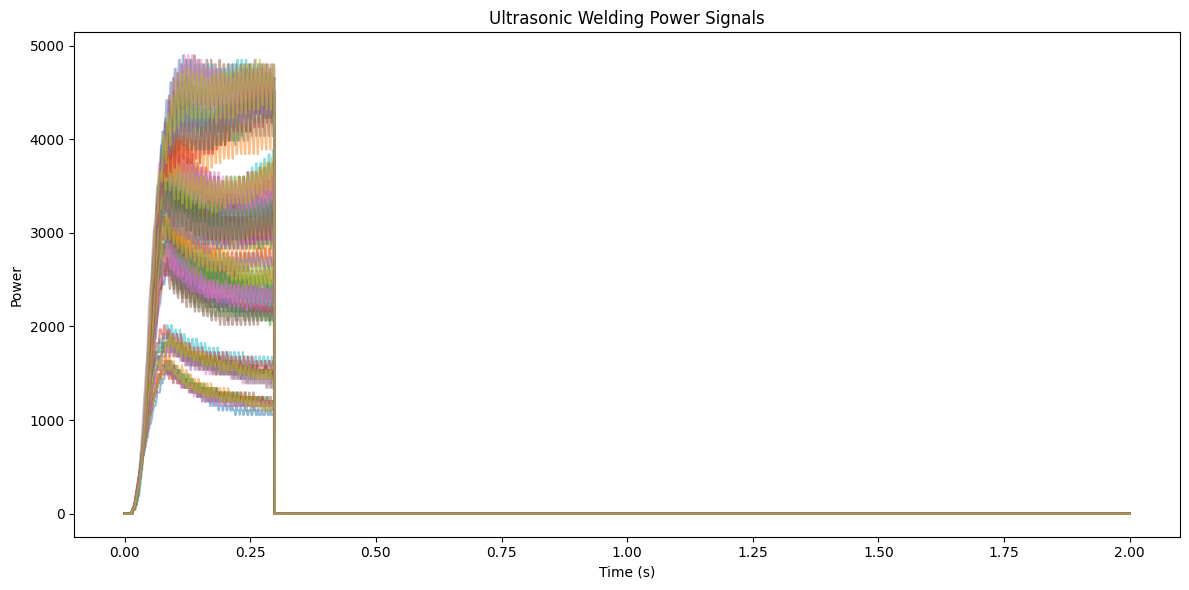

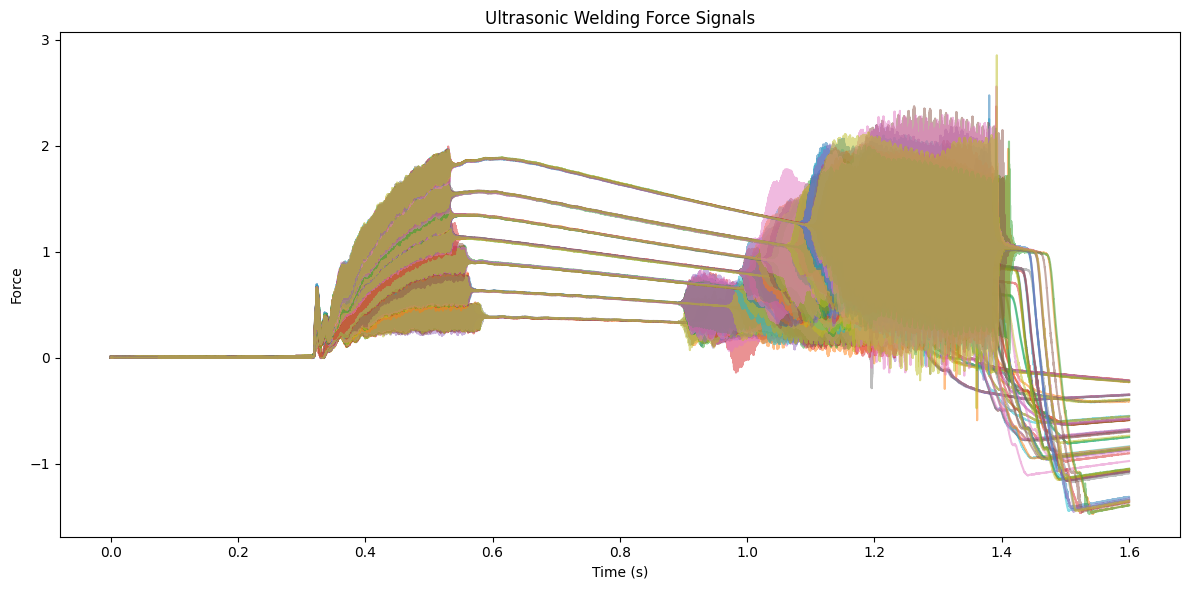

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

base_folder = "/content/drive/MyDrive/Colab Notebooks/part3/part3"

power_folder = os.path.join(base_folder, "Power_Signals")
force_folder = os.path.join(base_folder, "Force_Signals")

power_files = sorted(glob.glob(os.path.join(power_folder, "*.TXT")))
force_files = sorted(glob.glob(os.path.join(force_folder, "*.TXT")))

print(f"Found {len(power_files)} power signal files")
print(f"Found {len(force_files)} force signal files")

power_signals = []
force_signals = []

# === Load power signals ===
for file in power_files:
    data = np.loadtxt(file)
    t = data[:, 0]
    y = data[:, 1]
    power_signals.append((t, y))

# === Load force signals ===
for file in force_files:
    data = np.loadtxt(file)
    t = data[:, 0]
    y = data[:, 1]
    force_signals.append((t, y))

print(f"Loaded {len(power_signals)} power signals and {len(force_signals)} force signals")

# === Plot Power Signals ===
plt.figure(figsize=(12, 6))
for t, y in power_signals:
    plt.plot(t, y, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Power")
plt.title("Ultrasonic Welding Power Signals")
plt.tight_layout()
plt.show()

# === Plot Force Signals ===
plt.figure(figsize=(12, 6))
for t, y in force_signals:
    plt.plot(t, y, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Force")
plt.title("Ultrasonic Welding Force Signals")
plt.tight_layout()
plt.show()


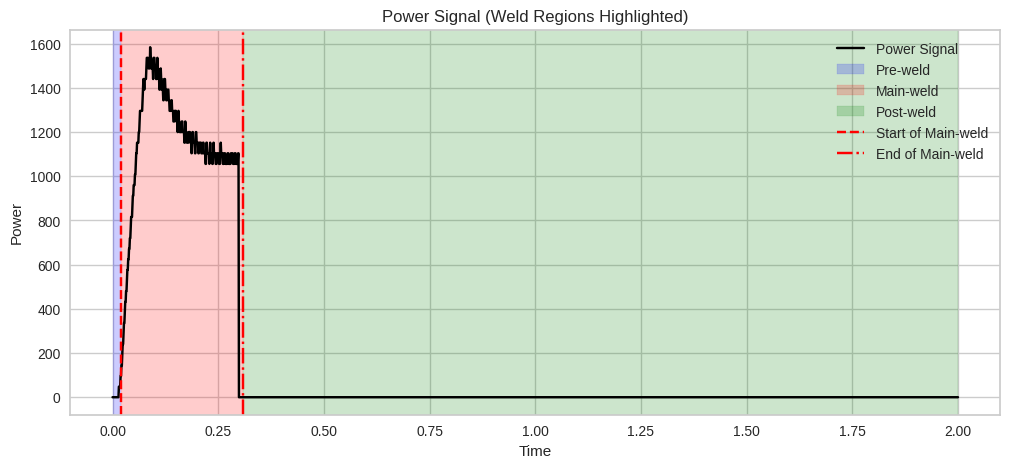

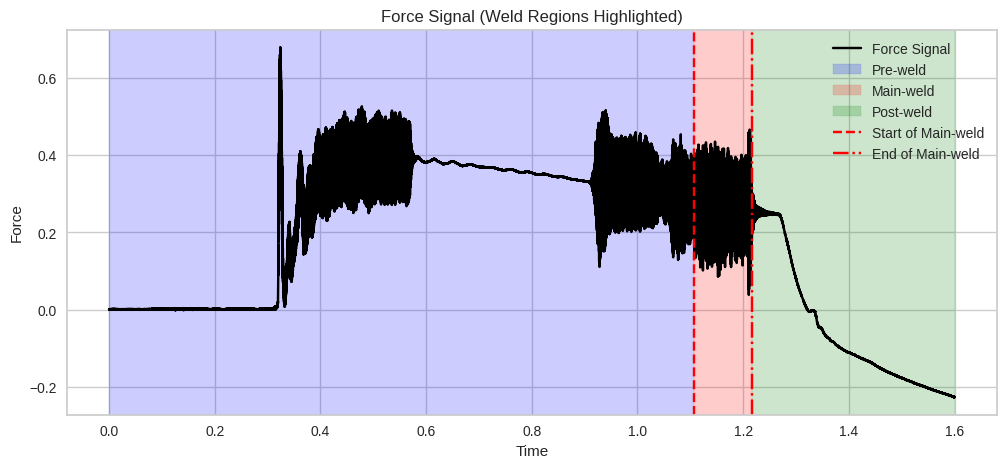

In [ ]:
# ===============================================================
# ================== PART 3a: Data Processing  ==================
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ===============================================================
# === MAIN-WELD EXTRACTION FOR POWER =============================
# ===============================================================

def extract_main_weld_power(t, y, frac=0.1):
    y_smooth = savgol_filter(y, 51, 3)

    peak = np.max(y_smooth)
    thresh = frac * peak

    start_idx = np.argmax(y_smooth > thresh)
    below = np.where(y_smooth[start_idx:] < thresh)[0]
    end_idx = start_idx + below[0] if len(below) else len(y) - 1

    return start_idx, end_idx


# ===============================================================
# === MAIN-WELD EXTRACTION FOR FORCE =============================
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def extract_main_weld_force_variance(t, y,
                                     smooth_window=101,
                                     grad_frac=0.02,
                                     var_window=100,
                                     var_percentile=70,
                                     min_segment_length=100):
    """
    Extract the main-weld region in force signals as the high-variance
    segment after the initial sharp rise.
    """
    if smooth_window % 2 == 0:
        smooth_window += 1
    y_smooth = savgol_filter(y, smooth_window, 3)

    # 1) Gradient
    dy = np.gradient(y_smooth, t)
    max_abs_dy = np.max(np.abs(dy)) if np.max(np.abs(dy)) > 0 else 1.0
    rise_thresh = grad_frac * max_abs_dy

    # 2) Initial sharp rise
    rise_indices = np.where(dy > rise_thresh)[0]
    if len(rise_indices) == 0:
        start_search = 0
    else:
        start_search = rise_indices[0]

    # 3) Sliding variance
    N = len(y_smooth)
    half = var_window // 2
    variances = np.zeros(N)
    for i in range(N):
        lo = max(0, i - half)
        hi = min(N, i + half)
        if hi - lo >= 3:
            variances[i] = np.var(y_smooth[lo:hi])
        else:
            variances[i] = 0.0

    # 4) Threshold variance
    thresh = np.percentile(variances, var_percentile)
    high_var = variances > thresh

    # 5) Find contiguous high-variance segments after initial rise
    segments = []
    in_seg = False
    seg_start = 0
    for i in range(start_search, N):
        v = high_var[i]
        if v and not in_seg:
            in_seg = True
            seg_start = i
        elif not v and in_seg:
            in_seg = False
            seg_end = i - 1
            if (seg_end - seg_start + 1) >= min_segment_length:
                segments.append((seg_start, seg_end))
    if in_seg:
        seg_end = N - 1
        if (seg_end - seg_start + 1) >= min_segment_length:
            segments.append((seg_start, seg_end))

    # 6) Choose the longest high-variance segment
    if segments:
        chosen = max(segments, key=lambda s: s[1] - s[0])
    else:
        # fallback: small window after initial rise
        chosen = (start_search, min(start_search + 50, N - 1))

    start_idx, end_idx = chosen
    return start_idx, end_idx



# ===============================================================
# === POWER SIGNAL PLOT: shaded regions + legend ===============
# ===============================================================

t_ex, y_ex = power_signals[0]
p_start, p_end = extract_main_weld_power(t_ex, y_ex)

plt.figure(figsize=(12,5))
plt.plot(t_ex, y_ex, label="Power Signal", color='black')

# Highlight regions
plt.axvspan(t_ex[0], t_ex[p_start], color='blue', alpha=0.2, label="Pre-weld")
plt.axvspan(t_ex[p_start], t_ex[p_end], color='red', alpha=0.2, label="Main-weld")
plt.axvspan(t_ex[p_end], t_ex[-1], color='green', alpha=0.2, label="Post-weld")

# Start/end vertical lines
plt.axvline(t_ex[p_start], color='red', linestyle='--', label="Start of Main-weld")
plt.axvline(t_ex[p_end], color='red', linestyle='-.', label="End of Main-weld")

plt.title("Power Signal (Weld Regions Highlighted)")
plt.xlabel("Time")
plt.ylabel("Power")
plt.legend()
plt.show()


# ===============================================================
# ========= FORCE SIGNAL PLOT: shaded regions + legend ==========
# ===============================================================

t_f, y_f = force_signals[0]
f_start, f_end = extract_main_weld_force_variance(t_f, y_f)

plt.figure(figsize=(12,5))
plt.plot(t_f, y_f, label="Force Signal", color='black')

# Highlight regions
plt.axvspan(t_f[0], t_f[f_start], color='blue', alpha=0.2, label="Pre-weld")
plt.axvspan(t_f[f_start], t_f[f_end], color='red', alpha=0.2, label="Main-weld")
plt.axvspan(t_f[f_end], t_f[-1], color='green', alpha=0.2, label="Post-weld")

# Start/end vertical lines
plt.axvline(t_f[f_start], color='red', linestyle='--', label="Start of Main-weld")
plt.axvline(t_f[f_end], color='red', linestyle='-.', label="End of Main-weld")

plt.title("Force Signal (Weld Regions Highlighted)")
plt.xlabel("Time")
plt.ylabel("Force")
plt.legend()
plt.show()


In [ ]:
# ===============================================================
# === PART 3b: Feature extraction & part3b.csv ==================
# ===============================================================

# 1. Load metadata (WeldClassification.csv) and clean header
meta_path = os.path.join(base_folder, "WeldClassification.csv")

# CSV exported from the original XLS: first few rows are description,
# header row appears later, so we read without header and fix it.
meta_raw = pd.read_csv(meta_path, header=None)

# Rows 0~5 are description, row 6 is header, data starts at row 7
df_runs_raw = meta_raw.iloc[6:].reset_index(drop=True)
header = df_runs_raw.iloc[0]
runs = df_runs_raw.iloc[1:].copy()
runs.columns = header
runs = runs.reset_index(drop=True)

# Convert numeric columns
numeric_cols = [
    "Run No.",
    "Amplitude [μm]",
    "Time [sec]",
    "Pressure [psi]",
    "Energy [J]",
    "Power [W]",
    "PreHeight [mm]",
    "Height [mm]",
    "Max. Load at Peel Test [N]",
]
for col in numeric_cols:
    runs[col] = pd.to_numeric(runs[col], errors="coerce")

# Map class label codes to text labels
label_map = {"I": "Cold", "II": "Excessive", "III": "Good"}
runs["Quality"] = runs["Class Label"].map(label_map)

# 2. Build mapping from run number to file paths
def get_run_no_from_path(path):
    """Extract integer run number from file name like 003_PWD_002.TXT."""
    fname = os.path.basename(path)
    num_str = fname.split("_")[-1].split(".")[0]
    return int(num_str)

power_by_run = {get_run_no_from_path(p): p for p in power_files}
force_by_run = {get_run_no_from_path(f): f for f in force_files}


# 3. Helper functions

def read_signal(path):
    """Load time and signal from a two-column TXT file."""
    data = np.loadtxt(path)
    t = data[:, 0]
    y = data[:, 1]
    return t, y


def get_indices_for_time_window(t, t_start, t_end):
    """Return index range that corresponds to a given time window."""
    mask = (t >= t_start) & (t <= t_end)
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return None
    return int(idx[0]), int(idx[-1])


def compute_features_for_run(run_no):
    """
    Compute Group A (process), Group B (power time-domain),
    and Group C (force frequency-domain) features for a single experiment.
    """
    row = runs[runs["Run No."] == run_no].iloc[0]

    # ----- Group A: process variables -----
    pressure = float(row["Pressure [psi]"])
    pre_h = float(row["PreHeight [mm]"])
    h = float(row["Height [mm]"])
    height_change = pre_h - h
    quality = row["Quality"]

    # File paths for this run
    power_path = power_by_run[run_no]
    force_path = force_by_run[run_no]

    # Load signals
    t_p, y_p = read_signal(power_path)
    t_f, y_f = read_signal(force_path)

    # ----- Main weld detection on power (reuse Part 3a function) -----
    p_start, p_end = extract_main_weld_power(t_p, y_p, frac=0.1)
    t_start = t_p[p_start]
    t_end = t_p[p_end]

    # Power segment
    y_p_seg = y_p[p_start:p_end + 1]
    dt_p = t_p[1] - t_p[0]

    # Group B: power features (time domain)
    P_mean = float(np.mean(y_p_seg))
    P_max = float(np.max(y_p_seg))
    P_std = float(np.std(y_p_seg))
    P_energy = float(np.trapz(y_p_seg, dx=dt_p))  # approximate integral

    # ----- Force segment: use the same time window as power -----
    seg_f = get_indices_for_time_window(t_f, t_start, t_end)
    if seg_f is None:
        raise RuntimeError(f"Cannot find matching force segment for run {run_no}")
    f_start, f_end = seg_f
    y_f_seg = y_f[f_start:f_end + 1]
    dt_f = t_f[1] - t_f[0]

    # Group C: force features (frequency domain)
    y_f_detrend = y_f_seg - np.mean(y_f_seg)
    N = len(y_f_detrend)
    Y = np.fft.rfft(y_f_detrend)
    freqs = np.fft.rfftfreq(N, dt_f)
    mag = np.abs(Y)

    # Remove DC component
    if len(mag) > 0:
        mag[0] = 0.0

    if len(mag) < 3:
        # In case something goes very wrong, fill with NaNs
        f1 = f2 = m1 = m2 = float("nan")
    else:
        idx_sorted = np.argsort(mag)[::-1]
        i1, i2 = idx_sorted[0], idx_sorted[1]
        # Sort the two peaks by frequency (lower first)
        if freqs[i1] <= freqs[i2]:
            f1, f2 = freqs[i1], freqs[i2]
            m1, m2 = mag[i1], mag[i2]
        else:
            f1, f2 = freqs[i2], freqs[i1]
            m1, m2 = mag[i2], mag[i1]

    return {
        "Experiment": run_no,
        "Quality": quality,
        # Group A
        "Pressure_psi": pressure,
        "PreHeight_mm": pre_h,
        "Height_mm": h,
        "HeightChange_mm": height_change,
        # Group B
        "P_mean": P_mean,
        "P_max": P_max,
        "P_std": P_std,
        "P_energy": P_energy,
        # Group C
        "F_peak1_freq_Hz": float(f1),
        "F_peak1_mag": float(m1),
        "F_peak2_freq_Hz": float(f2),
        "F_peak2_mag": float(m2),
    }


# 4. Loop over all runs and build part3b table
rows_out = []
for run_no in runs["Run No."]:
    run_no = int(run_no)
    if run_no not in power_by_run or run_no not in force_by_run:
        print(f"Skipping run {run_no} (missing signal file)")
        continue
    rows_out.append(compute_features_for_run(run_no))

df_part3b = pd.DataFrame(rows_out)

# 5. Save as part3b.csv (in current working directory)
df_part3b.to_csv("part3b.csv", index=False)

print(df_part3b.head())
print("part3b.csv saved, shape:", df_part3b.shape)


/tmp/ipython-input-1224292777.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P_energy = float(np.trapz(y_p_seg, dx=dt_p))  # approximate integral


   Experiment Quality  Pressure_psi  PreHeight_mm  Height_mm  HeightChange_mm  \
0           2    Cold          10.0          0.81       0.67             0.14   
1           3    Cold          10.0          0.83       0.67             0.16   
2           4    Cold          10.0          0.78       0.63             0.15   
3           5    Cold          10.0          0.81       0.67             0.14   
4           6    Cold          10.0          0.83       0.67             0.16   

        P_mean   P_max       P_std  P_energy  F_peak1_freq_Hz  F_peak1_mag  \
0  1111.333333  1584.0  334.511916   319.992     19950.524372     4.456785   
1  1228.432056  1728.0  355.009910   352.488     19943.358624     4.818183   
2  1207.000000  1632.0  351.612002   347.544     19947.040173     3.941262   
3  1173.073171  1584.0  334.583570   336.600     19943.358624     2.083155   
4  1172.000000  1632.0  333.274662   337.464     19947.040173     2.064045   

   F_peak2_freq_Hz  F_peak2_mag  
0     1995

Fisher ratios (sorted by FR_Sum):
            Feature  FR_Good_vs_Cold  FR_Good_vs_Excessive    FR_Sum
0             P_max         6.615842              1.975948  8.591790
1             P_std         5.408495              2.567004  7.975499
2          P_energy         5.428896              2.445577  7.874473
3            P_mean         5.396759              2.384200  7.780959
4      Pressure_psi         4.360209              3.390880  7.751088
5   HeightChange_mm         2.442170              2.867051  5.309222
6         Height_mm         1.853466              2.747458  4.600924
7   F_peak1_freq_Hz         2.382232              0.977738  3.359970
8   F_peak2_freq_Hz         2.990104              0.138107  3.128211
9      PreHeight_mm         0.786447              1.342081  2.128528
10      F_peak2_mag         0.903146              0.090250  0.993396
11      F_peak1_mag         0.770403              0.098645  0.869048

Saved Fisher ratio table to part3c_fisher_ratios.csv

Top 3 features

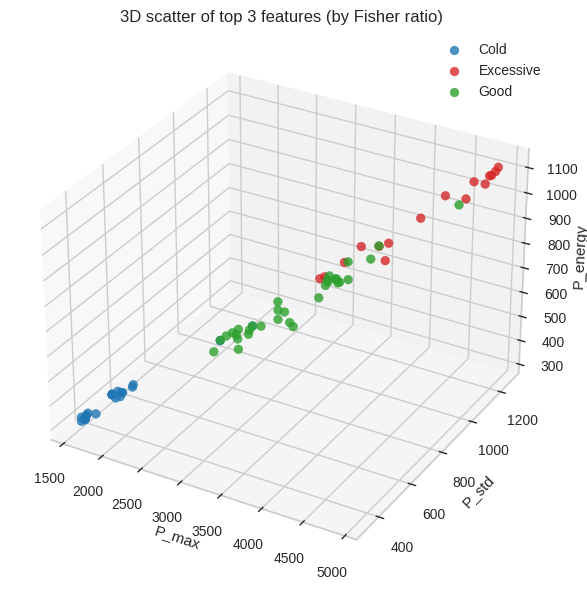

In [ ]:
# ===============================================================
# === PART 3c: Fisher ratio & 3D scatter ========================
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots

# 0. Use df_part3b if it exists, otherwise reload from CSV
try:
    df3 = df_part3b.copy()
except NameError:
    df3 = pd.read_csv("part3b.csv")

# 1. Define feature columns (exclude Experiment and Quality)
feature_cols = [c for c in df3.columns if c not in ["Experiment", "Quality"]]

# 2. Fisher ratio function
def fisher_ratio_two_class(x1, x2):
    """
    Compute Fisher ratio between two 1D numpy arrays:
    F = (mu1 - mu2)^2 / (sigma1^2 + sigma2^2)
    """
    x1 = np.asarray(x1, dtype=float)
    x2 = np.asarray(x2, dtype=float)

    # Drop NaNs
    x1 = x1[~np.isnan(x1)]
    x2 = x2[~np.isnan(x2)]

    if len(x1) == 0 or len(x2) == 0:
        return np.nan

    mu1 = np.mean(x1)
    mu2 = np.mean(x2)
    var1 = np.var(x1, ddof=1) if len(x1) > 1 else 0.0
    var2 = np.var(x2, ddof=1) if len(x2) > 1 else 0.0

    denom = var1 + var2
    if denom <= 0:
        return 0.0

    return (mu1 - mu2) ** 2 / denom


# 3. Compute Fisher ratios for each feature
results = []

for feat in feature_cols:
    x_good = df3.loc[df3["Quality"] == "Good", feat]
    x_cold = df3.loc[df3["Quality"] == "Cold", feat]
    x_excess = df3.loc[df3["Quality"] == "Excessive", feat]

    fr_good_cold = fisher_ratio_two_class(x_good, x_cold)
    fr_good_excess = fisher_ratio_two_class(x_good, x_excess)
    fr_sum = fr_good_cold + fr_good_excess

    results.append({
        "Feature": feat,
        "FR_Good_vs_Cold": fr_good_cold,
        "FR_Good_vs_Excessive": fr_good_excess,
        "FR_Sum": fr_sum,
    })

df_fr = pd.DataFrame(results)

# 4. Sort by FR_Sum (descending) and inspect
df_fr_sorted = df_fr.sort_values(by="FR_Sum", ascending=False).reset_index(drop=True)
print("Fisher ratios (sorted by FR_Sum):")
print(df_fr_sorted)

# Optionally save table for the report
df_fr_sorted.to_csv("part3c_fisher_ratios.csv", index=False)
print("\nSaved Fisher ratio table to part3c_fisher_ratios.csv")

# 5. Select top 3 features based on FR_Sum
top3 = df_fr_sorted["Feature"].head(3).tolist()
print("\nTop 3 features by Fisher ratio sum:", top3)

f1, f2, f3 = top3

# 6. 3D scatter plot using the top 3 features
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

color_map = {
    "Good": "tab:green",
    "Cold": "tab:blue",
    "Excessive": "tab:red",
}

for quality, group in df3.groupby("Quality"):
    ax.scatter(
        group[f1],
        group[f2],
        group[f3],
        label=quality,
        alpha=0.8,
        s=40,
        c=color_map.get(quality, "k"),
    )

ax.set_xlabel(f1)
ax.set_ylabel(f2)
ax.set_zlabel(f3)
ax.set_title("3D scatter of top 3 features (by Fisher ratio)")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
#-----------------------------------------------------------------
#-------------------- PART 3d: Classification --------------------
#-----------------------------------------------------------------

#1) Split df3 by class label
df_good=df3[df3["Quality"]=="Good"]
df_cold=df3[df3["Quality"]=="Cold"]
df_excess=df3[df3["Quality"]=="Excessive"]

print("Good:",df_good.shape)
print("Cold:",df_cold.shape)
print("Excessive:",df_excess.shape)

Good: (32, 14)
Cold: (21, 14)
Excessive: (16, 14)


In [ ]:
#2) Compute LCL and UCL for the 3 selected features using only Good data
selected_features=[f1,f2,f3]
limits={}
for feat in selected_features:
    mu=df_good[feat].mean()
    sig=df_good[feat].std()
    LCL=mu-3*sig
    UCL=mu+3*sig
    limits[feat]={
        "mean_good":mu,
        "std_good":sig,
        "LCL":LCL,
        "UCL":UCL,
    }
limits

{'P_max': {'mean_good': np.float64(3370.5),
  'std_good': 450.8958824098902,
  'LCL': np.float64(2017.8123527703294),
  'UCL': np.float64(4723.187647229671)},
 'P_std': {'mean_good': np.float64(768.7226222675181),
  'std_good': 126.58211755543873,
  'LCL': np.float64(388.9762696012019),
  'UCL': np.float64(1148.4689749338343)},
 'P_energy': {'mean_good': np.float64(710.71125),
  'std_good': 104.25581723105972,
  'LCL': np.float64(397.9437983068208),
  'UCL': np.float64(1023.4787016931791)}}

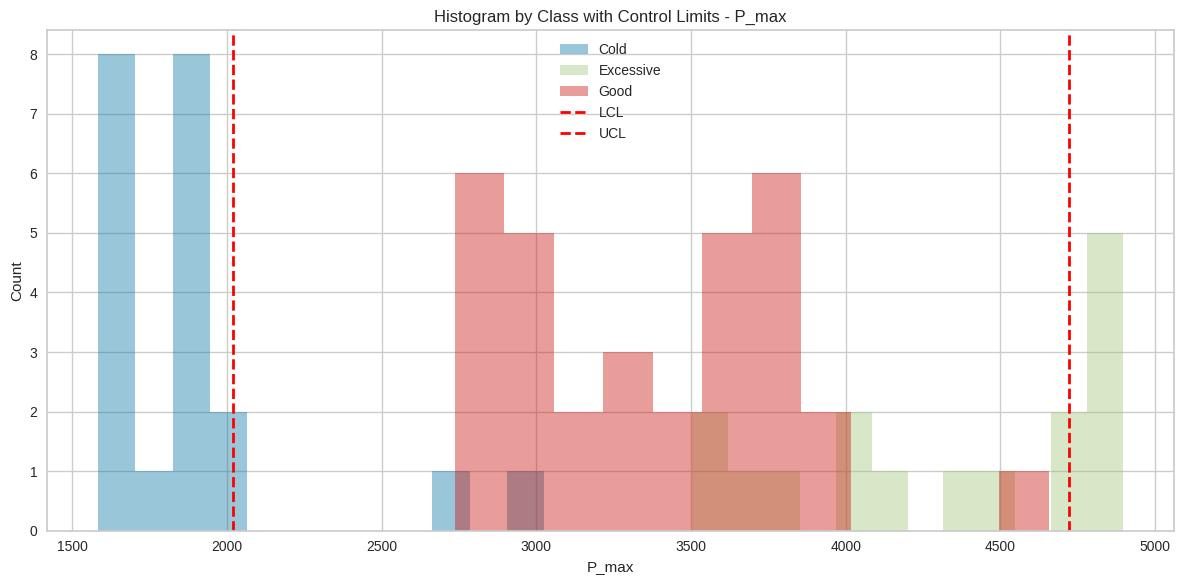

In [ ]:
#3)a) Histogram for the first selected feature
feat="P_max"
LCL=limits[feat]["LCL"]
UCL=limits[feat]["UCL"]

plt.figure(figsize=(12,6))
plt.hist(df_cold[feat],bins=12,alpha=0.4,label="Cold")
plt.hist(df_excess[feat],bins=12,alpha=0.4,label="Excessive")
plt.hist(df_good[feat],bins=12,alpha=0.4,label="Good")
plt.axvline(LCL,color="red",linestyle="--",linewidth=2,label="LCL")
plt.axvline(UCL,color="red",linestyle="--",linewidth=2,label="UCL")

plt.xlabel(feat)
plt.ylabel("Count")
plt.title(f"Histogram by Class with Control Limits - {feat}")
plt.legend()
plt.tight_layout()
plt.show()

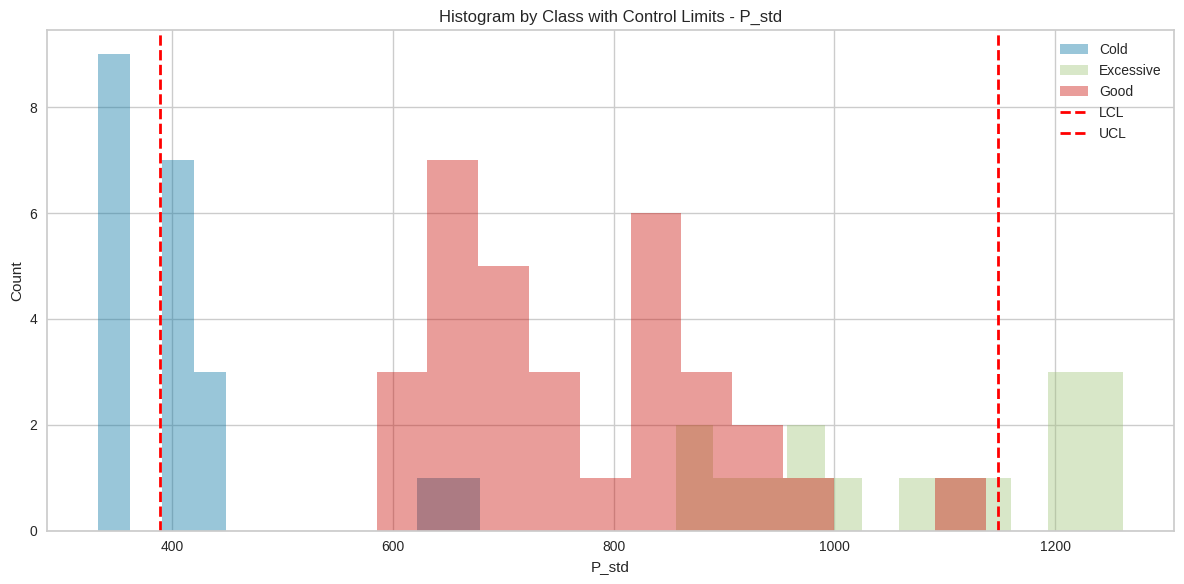

In [ ]:
#3)b) Histogram for the second selected feature
feat="P_std"
LCL=limits[feat]["LCL"]
UCL=limits[feat]["UCL"]

plt.figure(figsize=(12,6))
plt.hist(df_cold[feat],bins=12,alpha=0.4,label="Cold")
plt.hist(df_excess[feat],bins=12,alpha=0.4,label="Excessive")
plt.hist(df_good[feat],bins=12,alpha=0.4,label="Good")
plt.axvline(LCL,color="red",linestyle="--",linewidth=2,label="LCL")
plt.axvline(UCL,color="red",linestyle="--",linewidth=2,label="UCL")

plt.xlabel(feat)
plt.ylabel("Count")
plt.title(f"Histogram by Class with Control Limits - {feat}")
plt.legend()
plt.tight_layout()
plt.show()

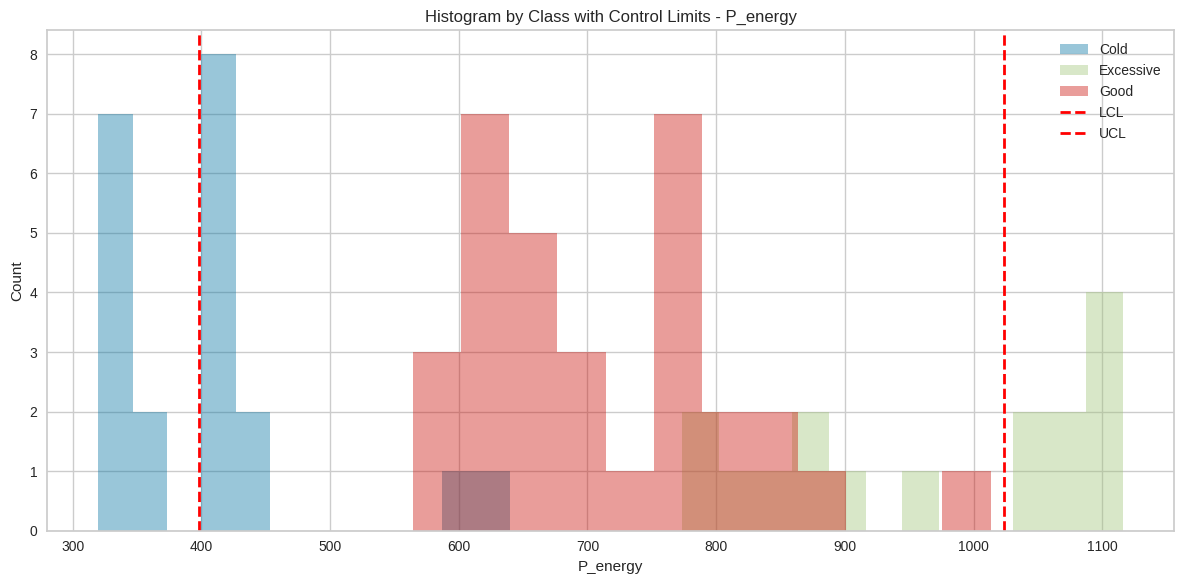

In [ ]:
#3)c) Histogram for the third selected feature
feat="P_energy"
LCL=limits[feat]["LCL"]
UCL=limits[feat]["UCL"]

plt.figure(figsize=(12,6))
plt.hist(df_cold[feat],bins=12,alpha=0.4,label="Cold")
plt.hist(df_excess[feat],bins=12,alpha=0.4,label="Excessive")
plt.hist(df_good[feat],bins=12,alpha=0.4,label="Good")
plt.axvline(LCL,color="red",linestyle="--",linewidth=2,label="LCL")
plt.axvline(UCL,color="red",linestyle="--",linewidth=2,label="UCL")

plt.xlabel(feat)
plt.ylabel("Count")
plt.title(f"Histogram by Class with Control Limits - {feat}")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#4) Misdetection Rate
def misdetection_rate(df,feat,LCL,UCL):
  true_good=df["Quality"]=="Good"
  pred_good=(df[feat]>=LCL) & (df[feat]<=UCL)
  mis=(true_good!=pred_good).mean()
  return mis

In [ ]:
#4)a) Misdetection Rate for the first selected feature
feat="P_max"
LCL=limits[feat]["LCL"]
UCL=limits[feat]["UCL"]
mis_Pmax=misdetection_rate(df3,feat,LCL,UCL)
print(f"Misdetection rate for {feat}: {mis_Pmax:.2%}")

Misdetection rate for P_max: 18.84%


In [ ]:
#4)b) Misdetection Rate for the second selected feature
feat="P_std"
LCL=limits[feat]["LCL"]
UCL=limits[feat]["UCL"]
mis_Pstd=misdetection_rate(df3,feat,LCL,UCL)
print(f"Misdetection rate for {feat}: {mis_Pstd:.2%}")

Misdetection rate for P_std: 30.43%


In [ ]:
#4)c) Misdetection Rate for the third selected feature
feat="P_energy"
LCL=limits[feat]["LCL"]
UCL=limits[feat]["UCL"]
mis_Penergy=misdetection_rate(df3,feat,LCL,UCL)
print(f"Misdetection rate for {feat}: {mis_Penergy:.2%}")

Misdetection rate for P_energy: 28.99%


3)e) Sensor Analysis

Based on the results from Parts 3b–3d, the power signal is more useful for weld-quality monitoring than the force signal. All three features selected in Part 3c (P_max, P_std, P_energy) were derived from the power signal, which indicates that power-based characteristics carry stronger discriminative information between Cold, Good, and Excessive welds. In addition, the misdetection rates for these power-based features (18.84%, 30.43%, and 28.99%) were consistently lower than what we would obtain from the force-based frequency-domain features. Overall, both the Fisher-ratio ranking and the misdetection analysis show that power features separate the classes more effectively, making the power sensor the more reliable choice for process quality monitoring.

In [ ]:
# ===============================================================
# ================= PART 4a: Feature Selection ==================
# ===============================================================

import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

data_path = "/content/drive/MyDrive/Colab Notebooks/part4/part4.csv"
df = pd.read_csv(data_path)

X = df.iloc[:, 2:] # Features
y = df.iloc[:, 1] # Classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # Dataset Split

model = LDA() # Model selection for the forward selection
forward_feature_selection = SequentialFeatureSelector(model,
                                                      k_features=(1,12),
                                                      forward=True,
                                                      floating=False,
                                                      verbose=2,
                                                      scoring="accuracy",
                                                      cv=5).fit(X_train, y_train)

selected_features_name = list(forward_feature_selection.k_feature_names_)

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished

[2025-12-10 19:51:03] Features: 1/12 -- score: 0.8955555555555555[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s finished

[2025-12-10 19:51:03] Features: 2/12 -- score: 0.9155555555555555[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished

[2025-12-10 19:51:04] Features: 3/12 -- score: 0.9355555555555555[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished

[2025-12-10 19:51:04] Features: 4/12 -- score: 0.9355555555555555[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s finished

[2025-12-10 19:51:04] Features: 5/12 -- score: 0.9355555555555555[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished

[2025-12-10 19:51:04] Features: 6/12 -- score: 0.9355555555555555[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished

[2025-12-10 19:51:04] Features: 7/12 -- score: 0.9155555555555555[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

In [ ]:
selected_features_name

['Feature 1', 'Feature 7', 'Feature 8']

<p1>4.a) Based on the forward selection feature selection with the greedy algorithm, Feature 1, Feature 7, and Feature 8 seem to be the best combination for classification with highest scores with accuracy scoring. Although other methods such as filter methods could be implemented with feature selections, the forward selection is chosen due to the size of the dataset and the number of the features. The magnitude of them would not cause heavy computational resources. Also, since there are more than 2 classes, it is improper to apply fisher's score, which is commonly used for the filter method.

In [ ]:
# ===============================================================
# ================= PART 4b: Classification =====================
# ===============================================================

from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN

X_filtered = df[selected_features_name]
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.3, random_state=42)

lda = LDA()
lda.fit(X_train, y_train)
lda_pred = lda.predict(X_test)
print("LDA Accuracy: ", accuracy_score(y_test, lda_pred))

qda = QDA(reg_param=0.1)
qda.fit(X_train, y_train)
qda_pred = qda.predict(X_test)
print("QDA Accuracy: ", accuracy_score(y_test, qda_pred))

knn = KNN()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KNN Accuracy: ", accuracy_score(y_test, knn_pred))

LDA Accuracy:  1.0
QDA Accuracy:  0.9047619047619048
KNN Accuracy:  1.0


<p1>4.b) The dataset is splitted into the train and test datasets with no validation set since the dataset is small. The ratio of the train and test datasets is 5:1. Three classification models are chosen for training: LDA, QDA, and KNN. The reg_param for the QDA model is increased to 0.1 to avoid singular covariance matrix. Training is done with scikit_learn library and the performance is checked; KNN has the highest performance while LDA and QDA has lower and the same accuracy since the dataset is normalized.

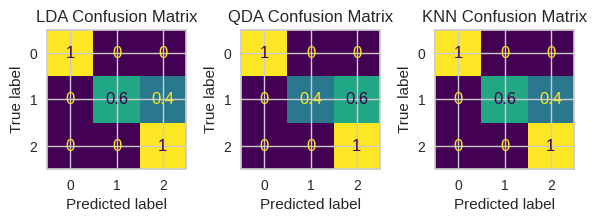

In [ ]:
# ===============================================================
# ================= PART 4c: Evaluation =====================
# ===============================================================

# Confusion Matrix Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(6, 14))
axes = axes.flatten()

# LDA
lda_cm = confusion_matrix(y_test, lda_pred, normalize='true')
ConfusionMatrixDisplay(lda_cm).plot(ax=axes[0], colorbar=False)
axes[0].set_title("LDA Confusion Matrix")

# QDA
qda_cm = confusion_matrix(y_test, qda_pred, normalize='true')
ConfusionMatrixDisplay(qda_cm).plot(ax=axes[1], colorbar=False)
axes[1].set_title("QDA Confusion Matrix")

# KNN
knn_cm = confusion_matrix(y_test, knn_pred, normalize='true')
ConfusionMatrixDisplay(knn_cm).plot(ax=axes[2], colorbar=False)
axes[2].set_title("KNN Confusion Matrix")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


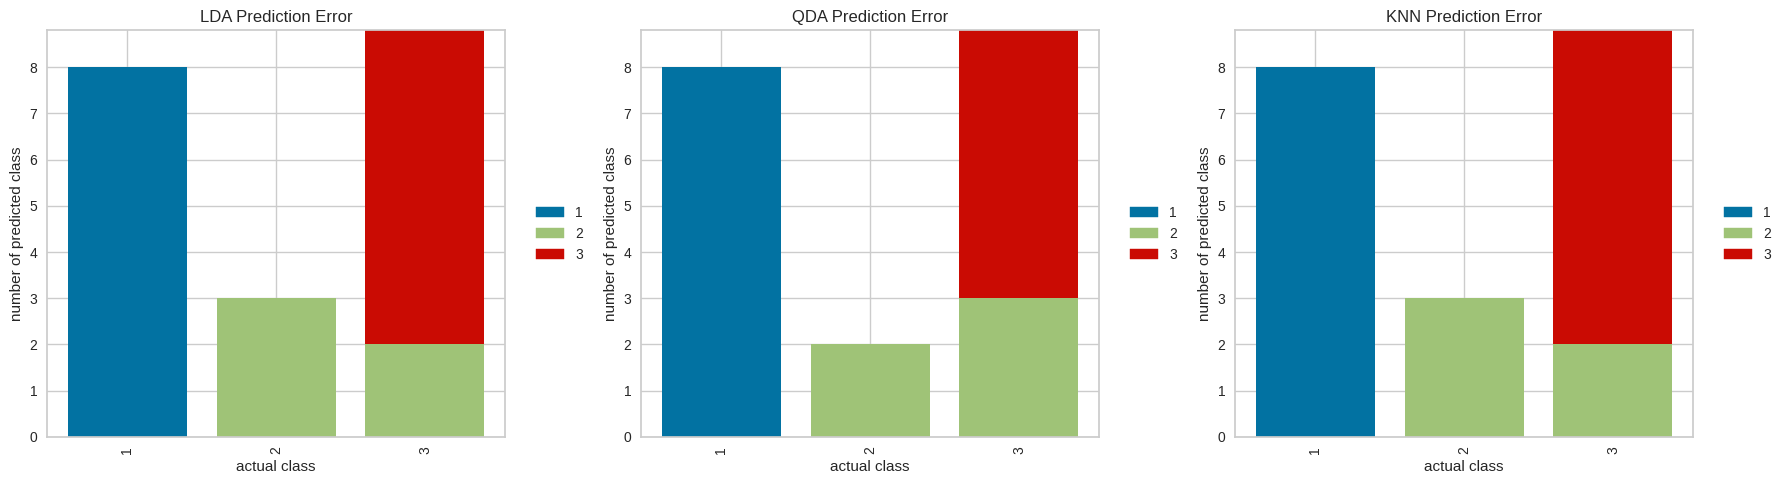

In [ ]:
# Error Plot
from yellowbrick.classifier import ClassPredictionError

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

# LDA
lda_viz = ClassPredictionError(estimator=lda, ax=axes[0])
lda_viz.fit(X_train, y_train)
lda_viz.score(X_test, y_test)
lda_viz.finalize()
axes[0].set_title("LDA Prediction Error")

# QDA
qda_viz = ClassPredictionError(estimator=qda, ax=axes[1])
qda_viz.fit(X_train, y_train)
qda_viz.score(X_test, y_test)
qda_viz.finalize()
axes[1].set_title("QDA Prediction Error")

# KNN
knn_viz = ClassPredictionError(estimator=knn, ax=axes[2])
knn_viz.fit(X_train, y_train)
knn_viz.score(X_test, y_test)
knn_viz.finalize()
axes[2].set_title("KNN Prediction Error")

plt.tight_layout()
plt.show()

